# **Laboratory Task 7**

---

### **Dataset Overview**

**Title:** Flower Image Dataset \
**Source:** [Kaggle – Flower Image Dataset](https://www.kaggle.com/datasets/aksha05/flower-image-dataset)

**Description:**
This dataset contains a diverse collection of flower images across multiple species, created for image classification and computer vision tasks. Each image is labeled according to its flower type, which can be identified from the filename (e.g., *tulip_00023.jpg*).

**Original Classes (10):** Tulips, Orchids, Peonies, Hydrangeas, Lilies, Gardenias, Garden Roses, Daisies, Hibiscus, and Bougainvillea.

**Selected Classes (5):** Tulips, Orchids, Peonies, Hydrangeas, and Lilies — chosen for model training and evaluation.

### **Experiment Setup**

| **Component**                   | **Description / Configuration**                                                                                                                        |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------ |                                                  
| **Input Image Size**            | 64 × 64 RGB                                                                                                                                            |
| **Model Architecture**          | **SimpleCNN** — a custom convolutional neural network                                                                                                  |
| **Convolutional Layers**        | 3 Conv2D layers:<br>• Conv1: 3 → 32 filters (3×3, padding=1)<br>• Conv2: 32 → 64 filters (3×3, padding=1)<br>• Conv3: 64 → 64 filters (3×3, padding=1) |
| **Pooling Layers**              | MaxPool2D (2×2, stride=2) after Conv1 and Conv2                                                                                                        |
| **Fully Connected Layers**      | • FC1: 64×16×16 → 64<br>• FC2: 64 → *num_classes*                                                                                                      |
| **Activation Functions Tested** | ReLU, LeakyReLU, ELU, Sigmoid, Tanh                                                                                                                    |
| **Output Layer**                | Linear (no activation, as `CrossEntropyLoss` applies `LogSoftmax` internally)                                                                          |
| **Loss Function**               | Cross-Entropy Loss                                                                                                                                     |
| **Optimizer**                   | Adam Optimizer                                                                                                                                         |
| **Learning Rate**               | 0.001                                                                                                                                                  |
| **Batch Size**                  | 32                                                                                                                                |
| **Device**                      | GPU (CUDA) if available, otherwise CPU                                                                                                                 |
| **Evaluation Metrics**          | Training & Validation Loss, Accuracy, and Test Accuracy                                                                                                |
| **Experiment Variation**        | Each activation function is used to train an identical CNN model independently, with the same training setup and optimizer.                            |

In [1]:
# Standard Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# TorchVision Utilities
import torchvision
import torchvision.transforms as transforms

In [2]:
# CUSTOM DATASET CLASS

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        
        # Filter image files based on the selected classes
        self.classes = ['Tulip', 'Orchids', 'Peonies', 'Hydrangeas', 'Lilies'] # Reduced to 5 classes
        self.class_to_idx = {cls.lower(): i for i, cls in enumerate(self.classes)}

        self.image_files = []
        for filename in os.listdir(data_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                label_name = filename.split('_')[0].lower()

                if label_name in self.class_to_idx:
                    self.image_files.append(filename)


        # Add a default transform for resizing if no transform is provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((64, 64)), # Resize images to a fixed size
                transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
            ])
        else:
            self.transform = transform


    def __len__(self):
        return len(self.image_files)

    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert('RGB') # Ensure image is RGB

        # Extract label from filename
        label_name = img_name.split('_')[0].lower() # Convert extracted label to lowercase
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Create an instance of the CustomDataset
dataset_path = 'flowers'
flower_dataset = CustomDataset(dataset_path)

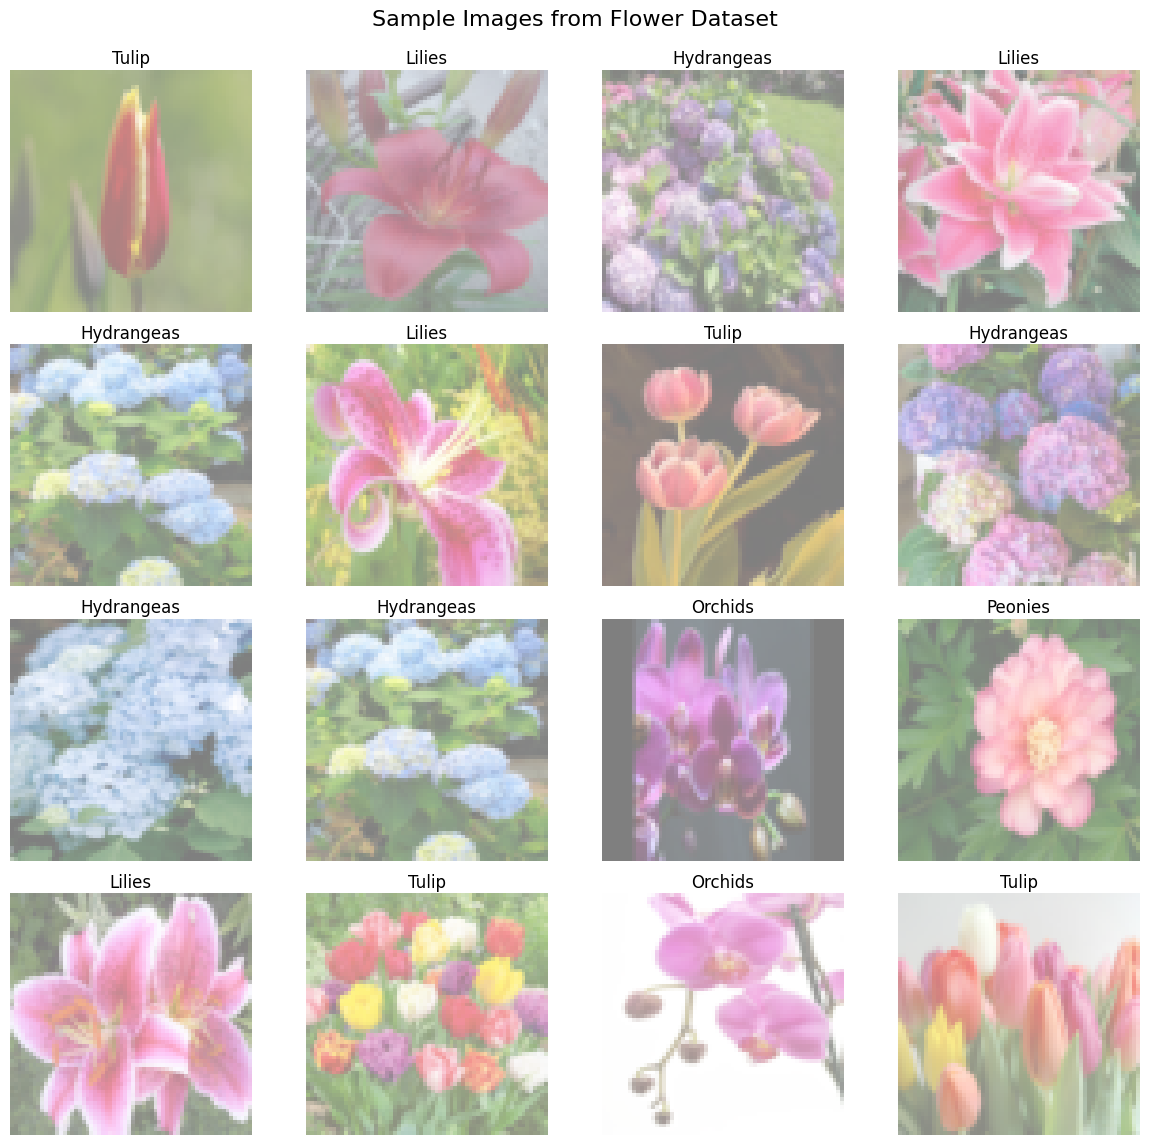

In [4]:
# Create DataLoader for instance visualization only
dataloader = DataLoader(flower_dataset, batch_size=16, shuffle=True)

# Get a batch of data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Class names
class_names = flower_dataset.classes

# Function to show a batch of images
def show_images_with_labels(images, labels, class_names, n_rows=4, n_cols=4):
    
    # Set up the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    fig.suptitle("Sample Images from Flower Dataset", fontsize=16, fontweight='regular', y=0.95)
    axes = axes.flatten()

    # Loop through batch and display each image
    for i, ax in enumerate(axes):
        if i < len(images):
            img = images[i] / 2 + 0.5  # Unnormalize if normalized to [-1, 1]
            npimg = img.cpu().numpy()
            npimg = np.transpose(npimg, (1, 2, 0))
            
            ax.imshow(npimg)
            ax.set_title(class_names[labels[i]], fontsize=12, pad=4)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Display the labeled grid
show_images_with_labels(images, labels, class_names)

In [5]:
# UTILITY FUNCTIONS

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

In [6]:
# Define proportions for the splits
train_size = int(0.7 * len(flower_dataset))
val_size = int(0.15 * len(flower_dataset))
test_size = len(flower_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(flower_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 245
Validation dataset size: 52
Testing dataset size: 54


In [7]:
# SIMPLE CONVOLUTIONAL NEURAL NETWORK MODEL

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, activation='relu'):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.activation = self._get_activation(activation)

    def _get_activation(self, activation_name):
        if activation_name == 'relu':
            return nn.ReLU()
        elif activation_name == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation_name == 'elu':
            return nn.ELU()
        elif activation_name == 'sigmoid':
            return nn.Sigmoid()
        elif activation_name == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {activation_name}")

    def forward(self, x):
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = self.activation(self.conv3(x))
        
        # Calculate the flattened size dynamically
        flattened_size = x.size(1) * x.size(2) * x.size(3)
        x = x.view(-1, flattened_size) # Flatten the tensor
        x = self.activation(self.fc1(x))

        # No activation on output layer for cross-entropy loss
        x = self.fc2(x)
        return x


activation_functions = ['relu', 'leakyrelu', 'elu', 'sigmoid', 'tanh']
num_classes = len(flower_dataset.classes)

models_and_optimizers = {}

for activation_name in activation_functions:
    
    # Create model instance
    model = SimpleCNN(num_classes, activation=activation_name)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Store in dictionary
    models_and_optimizers[activation_name] = {
        'model': model,
        'criterion': criterion,
        'optimizer': optimizer
    }

print("Models and optimizers created for the following activation functions:")
for activation_name in models_and_optimizers.keys():
    print(f"- {activation_name}")

Models and optimizers created for the following activation functions:
- relu
- leakyrelu
- elu
- sigmoid
- tanh


In [8]:
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for activation_name, components in models_and_optimizers.items():
    model = components['model'].to(device)
    criterion = components['criterion']
    optimizer = components['optimizer']

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    print(f"Training model with {activation_name} activation function...")

    for epoch in range(num_epochs):
        
        # Train
        train_loss, train_accuracy = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate_model(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Store the metrics
    models_and_optimizers[activation_name]['train_losses'] = train_losses
    models_and_optimizers[activation_name]['train_accuracies'] = train_accuracies
    models_and_optimizers[activation_name]['val_losses'] = val_losses
    models_and_optimizers[activation_name]['val_accuracies'] = val_accuracies

    print(f"Finished training for {activation_name}.\n")

Training model with relu activation function...
Epoch 5/30 - Train Loss: 1.2698, Train Acc: 0.4531, Val Loss: 1.2386, Val Acc: 0.3846
Epoch 10/30 - Train Loss: 0.8489, Train Acc: 0.6612, Val Loss: 1.1167, Val Acc: 0.5577
Epoch 15/30 - Train Loss: 0.4938, Train Acc: 0.8122, Val Loss: 0.9608, Val Acc: 0.6731
Epoch 20/30 - Train Loss: 0.1164, Train Acc: 0.9633, Val Loss: 1.3456, Val Acc: 0.6154
Epoch 25/30 - Train Loss: 0.0088, Train Acc: 1.0000, Val Loss: 1.6891, Val Acc: 0.6346
Epoch 30/30 - Train Loss: 0.0020, Train Acc: 1.0000, Val Loss: 1.8489, Val Acc: 0.6538
Finished training for relu.

Training model with leakyrelu activation function...
Epoch 5/30 - Train Loss: 1.0484, Train Acc: 0.6082, Val Loss: 1.2347, Val Acc: 0.4808
Epoch 10/30 - Train Loss: 0.5021, Train Acc: 0.8245, Val Loss: 1.0222, Val Acc: 0.6154
Epoch 15/30 - Train Loss: 0.0532, Train Acc: 0.9918, Val Loss: 1.4000, Val Acc: 0.5577
Epoch 20/30 - Train Loss: 0.0089, Train Acc: 1.0000, Val Loss: 1.8300, Val Acc: 0.5769
Ep

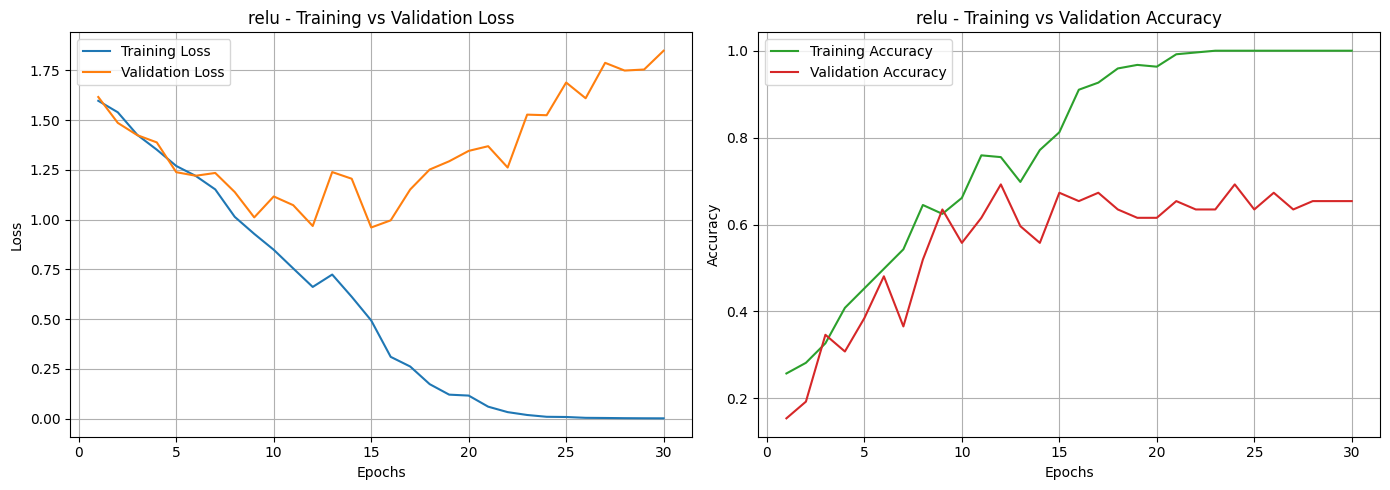

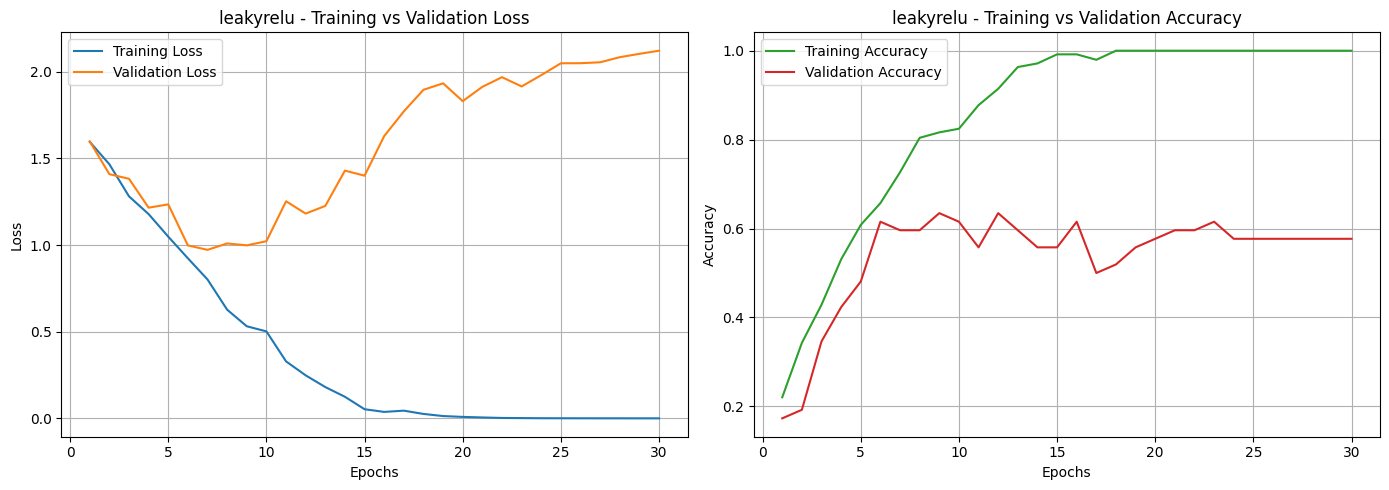

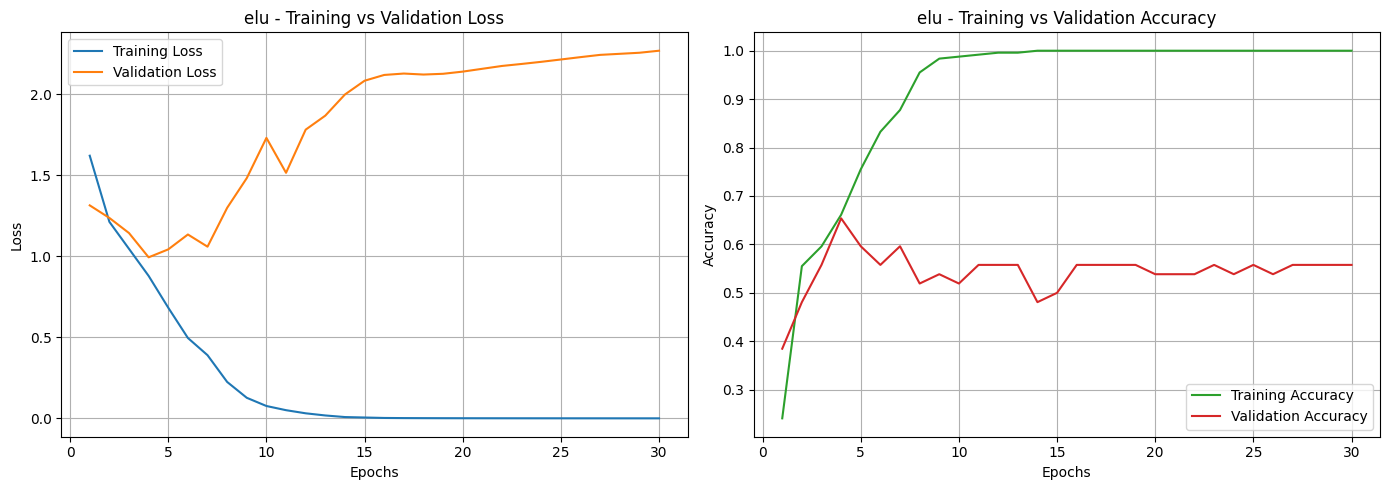

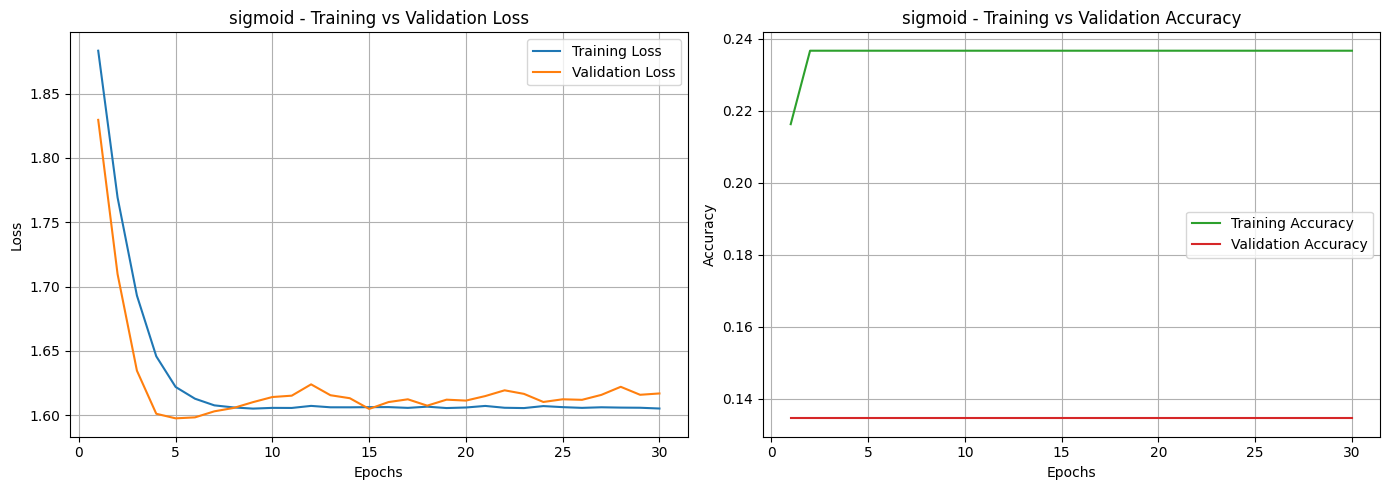

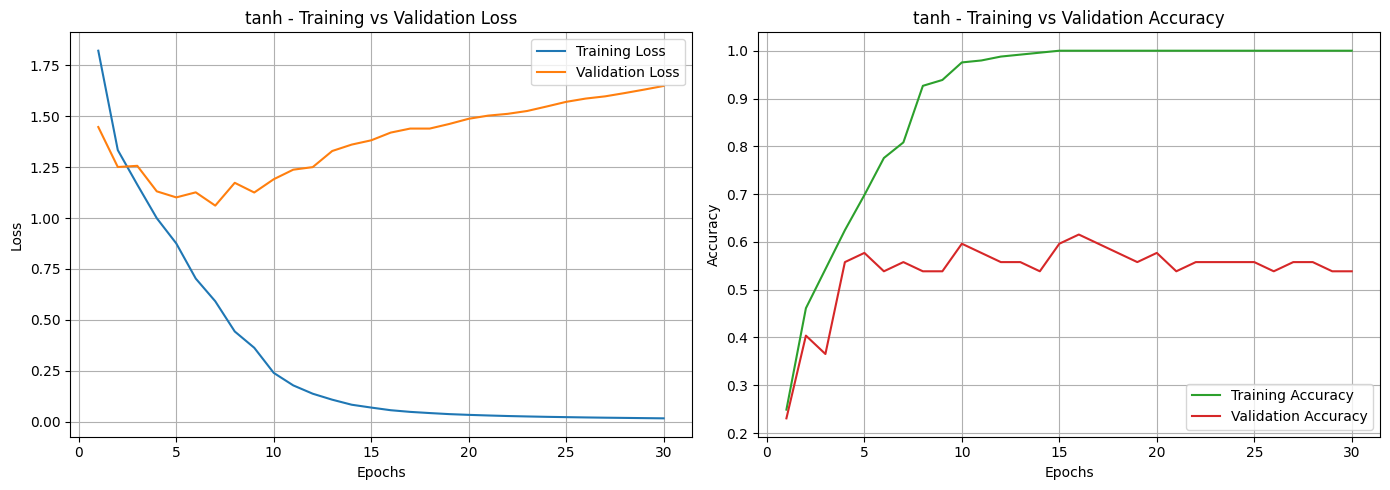

In [9]:
for activation_name, components in models_and_optimizers.items():
    train_losses = components['train_losses']
    val_losses = components['val_losses']
    train_accuracies = components['train_accuracies']
    val_accuracies = components['val_accuracies']
    num_epochs = len(train_losses)

    epochs = range(1, num_epochs + 1)

    # Create a single figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss
    axes[0].plot(epochs, train_losses, label='Training Loss', color='tab:blue')
    axes[0].plot(epochs, val_losses, label='Validation Loss', color='tab:orange')
    axes[0].set_title(f'{activation_name} - Training vs Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Accuracy
    axes[1].plot(epochs, train_accuracies, label='Training Accuracy', color='tab:green')
    axes[1].plot(epochs, val_accuracies, label='Validation Accuracy', color='tab:red')
    axes[1].set_title(f'{activation_name} - Training vs Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

Based on the loss and accuracy curves, we can see that almost all activation functions, except for Sigmoid, showed signs of overfitting. This can be noticed in the training and validation loss curves, where the two lines don’t stay close together. It means the models learned well on the training data but didn’t perform as well on unseen data. The same pattern can be seen in the accuracy curves, where most activation functions had a noticeable gap between training and validation accuracy. Among them, the Sigmoid function was the most affected, showing unstable performance and poor generalization.

This suggests that while the models were able to learn the patterns in the training set, they struggled to generalize to new data. To address this, techniques like dropout, batch normalization, or data augmentation could be applied to reduce overfitting. Adjusting the learning rate or using early stopping might also help make the training process more stable and improve overall performance.

In [12]:
# FINAL EVALUATION

# Initialize a dictionary to store test results
test_results = {}

# Determine computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop through all trained models
for activation_name, components in models_and_optimizers.items():

    # Retrieve model and loss criterion
    model = components['model'].to(device)
    criterion = components['criterion']

    # Evaluate the model on the test dataset
    test_loss, test_accuracy = evaluate_model(model, test_dataloader, criterion, device)

    # Store the results
    test_results[activation_name] = {
        'Test Loss': test_loss,
        'Test Accuracy': test_accuracy * 100  # convert to %
    }

# Summarize Results in a DataFrame
final_results = pd.DataFrame(test_results).T
final_results.index.name = "Activation Function"
final_results = final_results.sort_values(by='Test Accuracy', ascending=False)
display(final_results.style.format({'Test Loss': '{:.4f}', 'Test Accuracy': '{:.2f}%'}))

,Test Loss,Test Accuracy
Activation Function,,
leakyrelu,3.3259,55.56%
elu,2.7983,53.70%
tanh,1.6476,53.70%
relu,3.3157,50.00%
sigmoid,1.5942,29.63%


Among all the tested activation functions, LeakyReLU paired with the Adam optimizer gave the best overall performance, reaching a test accuracy of 55.56%. On the other hand, the Sigmoid function performed the weakest with only 29.63% accuracy, while Tanh and ELU achieved moderate and almost identical results of 53.70%. It’s worth noting that even though LeakyReLU had the highest accuracy, its test loss (3.3259) was slightly higher compared to ELU and Tanh. This means that while it made more correct predictions, the model’s confidence varied across different samples.

LeakyReLU likely performed better because it avoids the “dying ReLU” issue by allowing a small gradient to pass through even for negative inputs. This helps keep the training process smooth and prevents neurons from becoming inactive. The small negative slope also adds flexibility to the model, which can improve its ability to generalize to new data.

In contrast, the Sigmoid activation function struggled because it tends to saturate with large positive or negative values, causing vanishing gradients and slower learning. Meanwhile, Tanh and ELU offered more stable and balanced results, managing the gradients better than Sigmoid, but still not outperforming LeakyReLU in terms of overall classification accuracy.